# 3D Tic-Tac-Toe

## Objective and Prerequisites

Try this logic programming example to learn how to solve the problem of arranging X’s and O’s on a three-dimensional Tic-Tac-Toe board so as to minimize the number of completed lines or diagonals. This example will show you how a binary programming model can be used to capture simple logical constraints.

This is example 17 from the fifth edition of Model Building in Mathematical Programming by H. Paul Williams on pages 272 and 327 – 328.

This modeling example is at the beginning level. We assume that you have some familiarity with Python and the Gurobi Python API, but you can hopefully pick up any missing concepts from the example.

**Download the Repository** <br /> 
You can download the repository containing this and other examples by clicking [here](https://github.com/Gurobi/modeling-examples/archive/master.zip). 

---
## Problem Description

Given a 3-D tic-tac-toe board, where players take turns placing $X$'s and $O$'s, the game typically ends when one player completes a line or diagonal; that is, when they manage to place their symbols in three cells that form a line or diagonal in the grid.  The twist that is tackled here is that the game continues until every cell contains a symbol, and the goal is to arrange the symbols to minimize the number of completed lines or diagonals.

---
## Model Formulation


### Decision Variables

$\text{isX}_{ijk} \in [0,1]$: Does cell $(i,j,k)$ contain an $X$ ($isX=1$) or an $O$ ($isX=0$)?

$\text{isLine}_{l} \in [0,1]$: Does line/diagonal $l$ contain 3 of the same symbol?

### Objective Function

- **Lines**: Minimize the number of completed lines or diagonals

\begin{equation}
\text{Minimize} \quad Z = \sum_{l \in \text{Lines}}\text{isLine}_l
\end{equation}

### Constraints

- **Take turns**: The board must contain 14 $X$'s and 13 $O$'s ($X$ goes first).

\begin{equation}
\sum_{ijk} \text{isX}_{ijk} = 14
\end{equation}

- **Lines**: For a line to not be complete, one cell must have a different value.  The simple observation here is that the sum of the corresponding 3 binary variables would be 3 if they are all $X$ and 0 if they were all $O$.   We need to forbid those outcomes whenever $isLine_l == 0$.  Note that $l_0$ is the first cell in line $l$, $l_1$ is the second, and $l_2$ is the third.

\begin{equation}
\text{isLine}_l == 0 \implies isX[l_0] + isX[l_1] + isX[l_2] >= 1 \quad \forall l \in \text{Lines}
\end{equation}

\begin{equation}
\text{isLine}_l == 0 \implies isX[l_0] + isX[l_1] + isX[l_2] <= 2 \quad \forall l \in \text{Lines}
\end{equation}

---
## Python Implementation

We import the Gurobi Python Module.

In [1]:
import gurobipy as gp
from gurobipy import GRB

# tested with Python 3.7.0 & Gurobi 9.0

## Model Deployment

We first create a list of all possible lines and diagonals in a 3-D tic-tac-toe board.  Each is represented as a Python tuple with 3 entries, where each entry gives the (i,j,k) position of the corresponding cell.  There are 49 in total.

In [2]:
lines = []
size = 3

for i in range(size):
    for j in range(size):
        for k in range(size):
            if i == 0:
                lines.append(((0,j,k), (1,j,k), (2,j,k)))
            if j == 0:
                lines.append(((i,0,k), (i,1,k), (i,2,k)))
            if k == 0:
                lines.append(((i,j,0), (i,j,1), (i,j,2)))
            if i == 0 and j == 0:
                lines.append(((0,0,k), (1,1,k), (2,2,k)))
            if i == 0 and j == 2:
                lines.append(((0,2,k), (1,1,k), (2,0,k)))
            if i == 0 and k == 0:
                lines.append(((0,j,0), (1,j,1), (2,j,2)))
            if i == 0 and k == 2:
                lines.append(((0,j,2), (1,j,1), (2,j,0)))
            if j == 0 and k == 0:
                lines.append(((i,0,0), (i,1,1), (i,2,2)))
            if j == 0 and k == 2:
                lines.append(((i,0,2), (i,1,1), (i,2,0)))
lines.append(((0,0,0), (1,1,1), (2,2,2)))
lines.append(((2,0,0), (1,1,1), (0,2,2)))
lines.append(((0,2,0), (1,1,1), (2,0,2)))
lines.append(((0,0,2), (1,1,1), (2,2,0)))

Next we create our model and our decision variables.

In [3]:
model = gp.Model('Tic_Tac_Toe')
isX = model.addVars(size, size, size, vtype=GRB.BINARY, name="isX")
isLine = model.addVars(lines, vtype=GRB.BINARY, name="isLine")

Now we create the constraints.  The first states the board will contain 14 X's (and 13 O's):

In [4]:
x14 = model.addConstr(isX.sum() == 14)

The remaining constraints establish the relationship between the $isLine[]$ and $isX[]$ variables.  A line is complete if all three cells contain the same symbol.  In our model, this would correspond to three associated $isX[]$ variables summing to either 3 (all $X$) or 0 (all $O$).  For our purposes, it is enough to enforce the condition that if $isLine[] = 0$, the sum must be strictly between these two values.

In [5]:
for line in lines:
    model.addGenConstrIndicator(isLine[line], False, isX[line[0]] + isX[line[1]] + isX[line[2]] >= 1)
    model.addGenConstrIndicator(isLine[line], False, isX[line[0]] + isX[line[1]] + isX[line[2]] <= 2)

Finally, we set the optimization objective, which is to minimize the number of completed lines.

In [6]:
model.setObjective(isLine.sum())

Now we perform the optimization.

In [7]:
model.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: AMD Ryzen 7 7840HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 76 columns and 27 nonzeros
Model fingerprint: 0x9039be95
Model has 98 general constraints
Variable types: 0 continuous, 76 integer (76 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
  GenCon rhs range [1e+00, 2e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 98 rows and 0 columns
Presolve time: 0.00s
Presolved: 99 rows, 76 columns, 419 nonzeros
Variable types: 0 continuous, 76 integer (76 binary)
Found heuristic solution: objective 7.0000000
Found heuristic solution: objective 6.0000000

Root relaxation: objective 0.000000e+00, 42 iterations, 0.00 seconds (0.00 work units)

    N

---
## Result

The optimal solution completes only 4 lines or diagonals.  We can visualize the result using matplotlib (we've peeled off the third dimension of the 3-D tic-tac-toe board).

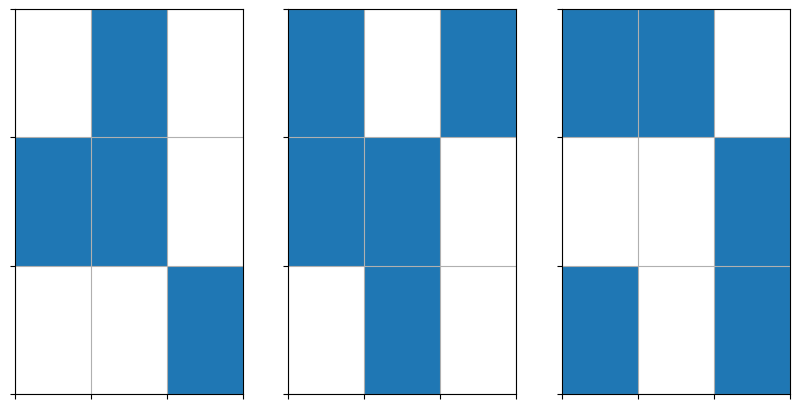

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(10,5))
for i in range(3):
    ax[i].grid()
    ax[i].set_xticks(range(4))
    ax[i].set_yticks(range(4))
    ax[i].tick_params(labelleft=False, labelbottom=False)
    
for cell in isX.keys():
    if isX[cell].x > 0.5:
        ax[cell[0]].add_patch(plt.Rectangle((cell[1],cell[2]), 1, 1))

plt.show()

---
## References

H. Paul Williams, Model Building in Mathematical Programming, fifth edition.

Copyright © 2020 Gurobi Optimization, LLC